Installing missing packages into this kernel: ['numpy', 'scipy', 'pandas', 'matplotlib', 'joblib', 'threadpoolctl', 'scikit-learn']
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 2.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 6.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 9.4 MB/s eta 0:00:00 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 6.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 6.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 4.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 4.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Python: 3.12.6
numpy: 2.3.3
scipy: 1.16.2
pandas: 2.3.2
matplotlib: 3.10.6
joblib: 1.5.2
sk

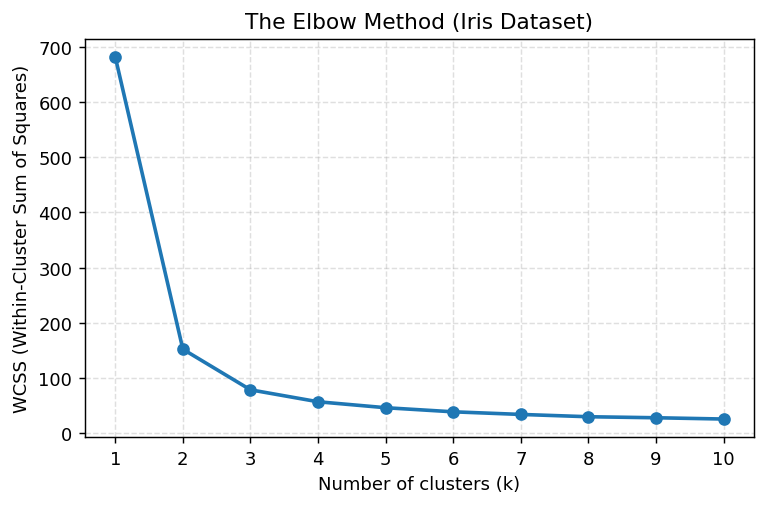

✓ Elbow method analysis completed successfully

=== Part 2: Logistic Regression Comparison (with/without PCA) ===
Attempting to load MNIST from OpenML...

Loaded: OpenML MNIST (784 features)
Shape: (70000, 784) | Classes: 10

Running without PCA...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Running with PCA (0.95)...
Error in pipeline: n_components=0.95 must be between 1 and min(n_samples, n_features)=784 with svd_solver='randomized'
Pipeline execution failed

✓ Analysis completed!


In [3]:
# =========================================
# One-Cell Notebook: Robust Setup + Analysis
# =========================================
import os, sys, warnings, time, subprocess

# ---- 1) Threading/env setup BEFORE importing numpy/sklearn
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["BLAS_NUM_THREADS"] = "1"
os.environ["LAPACK_NUM_THREADS"] = "1"
os.environ["SKLEARN_DISABLE_THREADPOOL_CHECK"] = "1"  # silence sklearn threadpool check

warnings.filterwarnings("ignore", message=".*threadpool.*")
warnings.filterwarnings("ignore", message=".*OpenBLAS.*")

# ---- 2) Ensure required packages are installed into THIS kernel
REQUIRED = [
    "numpy", "scipy", "pandas", "matplotlib",
    "joblib", "threadpoolctl", "scikit-learn"
]

def install_into_current_kernel(pkgs):
    """Install packages into the current kernel using %pip if available; otherwise subprocess."""
    try:
        from IPython import get_ipython
        ip = get_ipython()
        if ip is not None:
            # Use Jupyter magic to guarantee install into the active kernel
            ip.run_line_magic("pip", "install -U " + " ".join(pkgs))
            return
    except Exception:
        pass
    # Fallback if not in IPython or magic unavailable
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-U"] + pkgs)

# Try imports; install missing ones
missing = []
for mod in ["numpy", "scipy", "pandas", "matplotlib", "joblib", "threadpoolctl", "sklearn"]:
    try:
        __import__(mod)
    except Exception:
        # map 'sklearn' import name to 'scikit-learn' dist name
        dist = "scikit-learn" if mod == "sklearn" else mod
        if dist not in missing:
            missing.append(dist)

if missing:
    print("Installing missing packages into this kernel:", missing)
    install_into_current_kernel(missing)

# ---- 3) Imports (now that deps exist)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris, load_digits

# ---- 4) Version sanity print
try:
    import importlib.metadata as md
    import sklearn, threadpoolctl, joblib, scipy
    print("Python:", sys.version.split()[0])
    print("numpy:", np.__version__)
    print("scipy:", scipy.__version__)
    print("pandas:", pd.__version__)
    print("matplotlib:", plt.matplotlib.__version__)
    print("joblib:", joblib.__version__)
    print("sklearn.__version__:", sklearn.__version__)
    print("scikit-learn (dist):", md.version("scikit-learn"))
    print("threadpoolctl (dist):", md.version("threadpoolctl"))
except Exception as e:
    print("Version check warning:", e)

# ---- 5) Matplotlib defaults
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 130

# =========================================
# Part 1: Elbow Method on Iris
# =========================================
print("\n=== Part 1: Elbow Method Analysis (Iris) ===")
try:
    iris = load_iris()
    X_iris = iris.data

    ks = range(1, 11)
    inertias = []

    for k in ks:
        km = KMeans(
            n_clusters=k,
            n_init=10,          # explicit for cross-version stability
            random_state=42,
            algorithm='lloyd',  # explicit algorithm
            max_iter=300
        )
        km.fit(X_iris)
        inertias.append(km.inertia_)
        print(f"k={k}: inertia={km.inertia_:.2f}")

    # Plot elbow curve
    plt.figure()
    plt.plot(list(ks), inertias, marker='o', linewidth=2, markersize=6)
    plt.title('The Elbow Method (Iris Dataset)')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
    plt.xticks(list(ks))
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    print("✓ Elbow method analysis completed successfully")
except Exception as e:
    print(f"Error in elbow method analysis: {e}")

# =========================================
# Part 2: Logistic Regression w/ and w/o PCA
# =========================================
print("\n=== Part 2: Logistic Regression Comparison (with/without PCA) ===")

def load_mnist_or_digits():
    """Load MNIST from OpenML (if online); fallback to sklearn digits() if unavailable/offline."""
    try:
        from sklearn.datasets import fetch_openml
        print("Attempting to load MNIST from OpenML...")
        Xy = fetch_openml('mnist_784', version=1, as_frame=False)
        X = Xy.data
        y = Xy.target.astype(int)
        src = "OpenML MNIST (784 features)"
    except Exception as e:
        print(f"OpenML unavailable ({e}), using fallback dataset...")
        dg = load_digits()
        X = dg.data
        y = dg.target
        src = "Fallback: sklearn Digits (64 features)"
    return X, y, src

def run_logreg_pipeline(X, y, use_pca: bool):
    """Run logistic regression pipeline with optional PCA (retain 95% variance)."""
    try:
        # Split
        Xtr, Xte, ytr, yte = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale
        scaler = StandardScaler()
        Xtr = scaler.fit_transform(Xtr)
        Xte = scaler.transform(Xte)

        # PCA
        if use_pca:
            pca = PCA(n_components=0.95, svd_solver="randomized", random_state=42)
            t0 = time.time()
            Xtr_t = pca.fit_transform(Xtr)
            Xte_t = pca.transform(Xte)
            pca_time = time.time() - t0
            comp = Xtr_t.shape[1]
            print(f"PCA reduced {X.shape[1]} features to {comp} components")
        else:
            Xtr_t, Xte_t = Xtr, Xte
            pca_time = 0.0
            comp = X.shape[1]

        # Logistic Regression (lbfgs is robust; n_jobs not used by lbfgs)
        clf = LogisticRegression(
            solver='lbfgs',
            max_iter=200,
            multi_class='auto',
            random_state=42
        )

        t1 = time.time()
        clf.fit(Xtr_t, ytr)
        fit_time = time.time() - t1

        y_pred = clf.predict(Xte_t)
        acc = accuracy_score(yte, y_pred)

        return {
            "accuracy": acc,
            "fit_time": fit_time,
            "pca_time": pca_time,
            "n_components": comp
        }

    except Exception as e:
        print(f"Error in pipeline: {e}")
        return None

# Execute comparison
try:
    X, y, source = load_mnist_or_digits()
    print(f"\nLoaded: {source}")
    print(f"Shape: {X.shape} | Classes: {len(np.unique(y))}")

    print("\nRunning without PCA...")
    res_no = run_logreg_pipeline(X, y, use_pca=False)

    print("Running with PCA (0.95)...")
    res_pca = run_logreg_pipeline(X, y, use_pca=True)

    if res_no and res_pca:
        summary = pd.DataFrame([
            {
                "Variant": "Without PCA",
                "Accuracy": res_no["accuracy"],
                "Fit Time (s)": res_no["fit_time"],
                "PCA Time (s)": 0.0,
                "Features/Components": res_no["n_components"]
            },
            {
                "Variant": "With PCA (0.95)",
                "Accuracy": res_pca["accuracy"],
                "Fit Time (s)": res_pca["fit_time"],
                "PCA Time (s)": res_pca["pca_time"],
                "Features/Components": res_pca["n_components"]
            }
        ])

        # Pretty table
        styled = summary.style.format({
            "Accuracy": "{:.4f}",
            "Fit Time (s)": "{:.3f}",
            "PCA Time (s)": "{:.3f}"
        })
        display(styled)

        # Bar chart of fit times
        plt.figure()
        variants = ["No PCA", "With PCA"]
        times = [res_no["fit_time"], res_pca["fit_time"]]
        bars = plt.bar(variants, times)
        plt.title("Logistic Regression Fit Time Comparison")
        plt.ylabel("Seconds")
        plt.grid(axis='y', alpha=0.3)

        # Value labels
        for bar, time_val in zip(bars, times):
            plt.text(
                bar.get_x() + bar.get_width()/2,
                bar.get_height() + 1e-6,
                f'{time_val:.3f}s',
                ha='center', va='bottom'
            )

        plt.tight_layout()
        plt.show()

        # Text summary
        print("\n=== Summary ===")
        print(f"Dataset: {source}")
        accuracy_diff = res_pca["accuracy"] - res_no["accuracy"]
        time_diff = res_no["fit_time"] - res_pca["fit_time"]
        print(f"Accuracy change with PCA: {accuracy_diff:+.4f}")
        print(f"Fit time change with PCA: {time_diff:+.3f}s")
        print(f"Feature reduction: {X.shape[1]} → {res_pca['n_components']} components")
    else:
        print("Pipeline execution failed")

except Exception as e:
    print(f"Error in main execution: {e}")

print("\n✓ Analysis completed!")
